# Think Like a Machine - Chapter 3
Linear Regression with Multiple Variables
==================================

**ACKNOWLEDGEMENT**

**The contents of this notebook are adapted from John D. Wittenauer's notebooks that cover the exercises in Andrew Ng's course on Machine Learning on Coursera. This is mostly Wittenauer's and Ng's work and acknowledged as such.**

In [24]:
# Use the functions from another notebook in this notebook
%run SharedFunctions.ipynb

In [66]:
# Import our usual libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

## The Business Problem: Predicting Housing Prices

What's the market value of a house? One way to determine the market price is to collect up the prices of houses based on a few characteristics such as size in square feet and number of bedrooms. Then think like a machine and "learn" what the price should be based on this data.

The data we have is housing prices in Portland, Oregon. Let's see what it looks like.

## Load the Data

In [26]:
import os
path = os.getcwd() + '/Data/ex1data2.txt'
data2 = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [27]:
data2.describe()

,Size,Bedrooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [28]:
data2.Size.min()

852

We have information about 47 homes in this dataset. Each house is described by two characteristics or "features".

## Visualize the Data

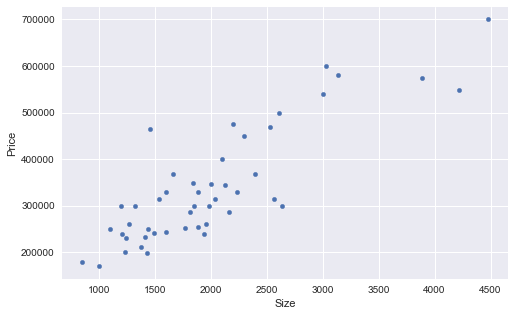

In [29]:
data2.plot.scatter(x='Size', y='Price', figsize=(8,5))

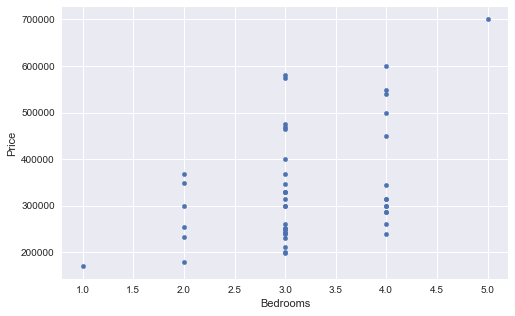

In [30]:
data2.plot.scatter(x='Bedrooms', y='Price', figsize=(8,5))

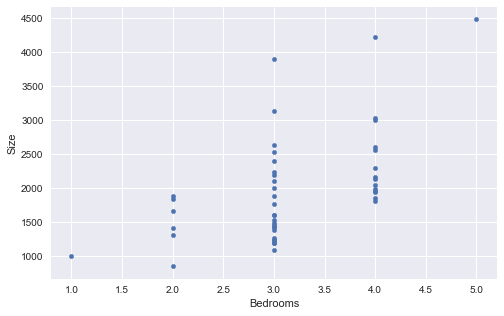

In [31]:
data2.plot.scatter(x='Bedrooms', y='Size', figsize=(8,5))

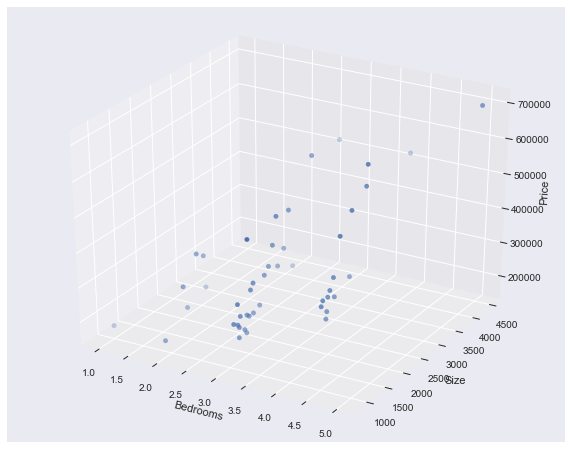

In [32]:
# 3D scatter plot -- just because...
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(10,8)).gca(projection='3d')
threedee.scatter(data2['Bedrooms'], data2['Size'], data2['Price'])
threedee.set_xlabel('Bedrooms')
threedee.set_ylabel('Size')
threedee.set_zlabel('Price')
plt.show()

## Rescale/Normalize the Data
Notice that the size of a house in square feet is about 1,000 times the number of bedrooms it has. Similarly, the price of a house is about 100 times the size of the house. This is quite common in many datasets, but when it happens, the iterative method of gradient descent (which we'll use again) becomes inefficient. This is simply a matter of making the computations efficient. To do so, we'll do something called *feature normalization*.

In [33]:
# Normalize the dataset
data2Norm = (data2 - data2.mean()) / data2.std()
data2Norm.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


In [106]:
# Let's keep track of the mean and standard deviation of the house sizes, number of bedrooms, and prices in the dataset.
# We'll need these values when we make predictions

# We can get them easily for size, bedrooms and price by using data2.mean()[0], ..., [2]
data2.mean()[0], data2.mean()[1], data2.mean()[2], data2.std()[0], data2.std()[1], data2.std()[2]

(2000.6808510638298,
 3.1702127659574466,
 340412.6595744681,
 794.70235353388966,
 0.76098188678009993,
 125039.89958640098)

## Step 1: Define the Inputs
In this case we have 2 inputs -- the size and number of bedrooms of the house. 

In [34]:
# Number of columns in the dataset
cols = data2Norm.shape[1]
# Inputs are our first two columns
X = data2Norm.iloc[:, 0:cols-1]
# Add an initial column of 1s to X to keep the notation simple
X.insert(0,'x0',1)

In [35]:
X.head()

,x0,Size,Bedrooms
0,1,0.130010,-0.223675
1,1,-0.504190,-0.223675
2,1,0.502476,-0.223675
3,1,-0.735723,-1.537767
4,1,1.257476,1.090417


## Step 2: Define the Output
The output is the house price. Let's set it up as a variable y.

In [36]:
# The output
y = data2Norm.iloc[:, cols-1:cols]

In [37]:
y.head()

,Price
0,0.475747
1,-0.084074
2,0.228626
3,-0.867025
4,1.595389


## Step 3: Define the Model
We're going to stick to a simple model -- exactly the same one as before but now with an additional input:

$$y = h_{\theta}(X) = \theta_{0} * x_{0}\ +\ \theta_{1} * x_{1} +\ \theta_{2} * x_{2}$$

It's still linear but now has more than 1 variable, hence the $x_{2}$.

## Step 4: Define the Parameters of the Model
$\theta_{0}$, $\theta_{1}$, and $\theta_{2}$ are the *parameters* of the model. Unlike our example of the boiling water in Chapter 1, these parameters can each take on an infinite number of values. $\theta_{0}$ is called the *bias value*.

With this model, we know exactly how to transform an input into an output -- that is, once the values of the parameters are given.

Let's pick a value of X from the dataset, fix a specific value for $\theta_{0}$ and $\theta_{1}$, and see what we get for the value of y.

Specifically, let
$\begin{bmatrix}
\theta_{0} \\
\theta_{1} \\
\theta_{2}
\end{bmatrix} = 
\begin{bmatrix}
-10 \\
1 \\
0
\end{bmatrix}$

This means $\theta_{0}$ is -10, $\theta_{1}$ is 1, and $\theta_{2}$ is 0.

Let's try out X * theta for the first few rows of X.

In [38]:
# Outputs generated by our model for the first 5 inputs with the specific theta values below
theta_test = np.matrix('-10;5;1.2')
outputs = np.matrix(X.iloc[0:5, :]) * theta_test
outputs

matrix([[ -9.61836088],
        [-12.78935942],
        [ -7.75602841],
        [-15.52393562],
        [ -2.40412008]])

In [39]:
# Compare these outputs to the actual values of y in the dataset
y.head()

,Price
0,0.475747
1,-0.084074
2,0.228626
3,-0.867025
4,1.595389


That's quite a bit off from the actual values; so we know that the values for $\theta$ in theta_test must be quite far from the optimal values for $\theta$ -- the values that will minimize the cost of getting it wrong.

## Step 5: Define the Cost of Getting it Wrong
Our cost function is exactly the same as it was before for the single variable case. 

The cost of getting it wrong is defined as a function $J(\theta)$:

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_{\theta}x^{(i)}) - y^{(i)})^2$$

The only difference from what we had before is in $h_{\theta}(x)$ which as a $\theta_{2}$ and $x_{2}$ now added as we saw above

$$h_{\theta}(X) = \theta_{0} * x_{0}\ +\ \theta_{1} * x_{1} +\ \theta_{2} * x_{2}$$

In [40]:
# Compute the cost for a given set of theta values over the entire dataset
# Get X and y in to matrix form
computeCost(np.matrix(X.values), np.matrix(y.values), theta_test)

62.012999752641328

We don't know yet if this is high or low -- we'll have to try out a whole bunch of $\theta$ values. Or better yet, we can use pick an iterative method and implement it.

## Step 6: Pick an Iterative Method to Minimize the Cost of Getting it Wrong

Once again, the method that will "learn" the optimal values for $\theta$ is gradient descent. We don't have to do a thing to the function we wrote before for gradient descent. Let's use it to find the minimum cost and the values of $\theta$ that result in that minimum cost.

In [41]:
theta_init = np.matrix('10;10;10')
# Run gradient descent for a number of different learning rates
alpha = [0.001, 0.003, 0.01, 0.03, 0.1]
iters = 500
theta_ag = np.matrix(np.zeros((3,5)))
cost_ag = np.zeros((5, iters))
for i in range(5):
    theta_opt, cost_min = gradientDescent(np.matrix(X.values), np.matrix(y.values), theta_init, alpha[i], iters)
    theta_ag[:,i] = theta_opt
    cost_ag[i,:] = cost_min

In [42]:
theta_ag[:, 4]

matrix([[ -1.05548614e-16],
        [  8.84765988e-01],
        [ -5.31788195e-02]])

In [43]:
#cost_ag[4,:]

In [44]:
# This is the value of theta for the last iteration above -- hence for alpha = 0.1
theta_opt

matrix([[ -1.05548614e-16],
        [  8.84765988e-01],
        [ -5.31788195e-02]])

In [45]:
# The last cost of the last iteration is the minimum that gradient descent was able to find
# See cost_ag[:,4] above to check the structure of this output
cost_min[-1]

0.13068648053904194

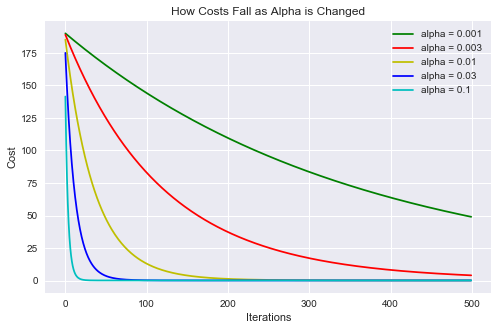

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(iters), cost_ag[0,:], 'g', label="alpha = 0.001")
ax.plot(np.arange(iters), cost_ag[1,:], 'r', label="alpha = 0.003")
ax.plot(np.arange(iters), cost_ag[2,:], 'y', label="alpha = 0.01")
ax.plot(np.arange(iters), cost_ag[3,:], 'b', label="alpha = 0.03")
ax.plot(np.arange(iters), cost_ag[4,:], 'c', label="alpha = 0.1")
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('How Costs Fall as Alpha is Changed')

## Results

It looks like a learning rate ($\alpha$ value) greater than 0.003 is good enough to get our iterative gradient descent to plunge down to arrive at the lowest cost value and stay there. 

Let's make some predictions...What is our prediction for a house that is 5,000 square feet in size with 4 bedrooms? Let's plug these in to our model and use the optimal $\theta$ values we've calculated above.

In [105]:
# Change size and num_bedrooms to make distinct predictions
size = 5000
num_bedrooms = 4

# Remember we've run the model using rescaled house sizes and number of bedrooms
# So we should scale the inputs down and then scale the prediction up when we're done
size_scaled = (size - data2.mean()[0])/data2.std()[0]
beds_scaled = (num_bedrooms - data2.mean()[1])/data2.std()[1]

# This is our model -- we're just using it here to make a calculation
pred_price = (theta_opt.item(0,0) * 1) + (theta_opt.item(1,0) * size_scaled) + (theta_opt.item(2,0) * beds_scaled)

# Now we re-re-scale the price to convert it back to the right order of magnitude
pred_price_real = (pred_price * data2.std()[2]) + data2.mean()[2]

# Format and print the result
print "Predicted Price: ", '{:20,.0f}'.format(math.ceil(pred_price_real))

Predicted Price:               750,700


You'll notice that the predicted prices are mostly driven by the size of the house; the number of bedrooms don't matter as much. In fact, there's something strange going on in our model; for a fixed house size, the price seems to go down as the number of bedrooms goes up! 